# 1. Data Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchani

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
def load_ani_dataset(dspath):
    self_energies = torch.tensor([
        0.500607632585, -37.8302333826,
        -54.5680045287, -75.0362229210
    ], dtype=torch.float, device=device)
    energy_shifter = torchani.utils.EnergyShifter(None)
    species_order = ['H', 'C', 'N', 'O']

    dataset = torchani.data.load(dspath)
    dataset = dataset.subtract_self_energies(energy_shifter, species_order)
    dataset = dataset.species_to_indices(species_order)
    dataset = dataset.shuffle()
    return dataset

In [4]:
def init_aev_computer():
    Rcr = 5.2
    Rca = 3.5
    EtaR = torch.tensor([16], dtype=torch.float, device=device)
    ShfR = torch.tensor([
        0.900000, 1.168750, 1.437500, 1.706250, 
        1.975000, 2.243750, 2.512500, 2.781250, 
        3.050000, 3.318750, 3.587500, 3.856250, 
        4.125000, 4.393750, 4.662500, 4.931250
    ], dtype=torch.float, device=device)


    EtaA = torch.tensor([8], dtype=torch.float, device=device)
    Zeta = torch.tensor([32], dtype=torch.float, device=device)
    ShfA = torch.tensor([0.90, 1.55, 2.20, 2.85], dtype=torch.float, device=device)
    ShfZ = torch.tensor([
        0.19634954, 0.58904862, 0.9817477, 1.37444680, 
        1.76714590, 2.15984490, 2.5525440, 2.94524300
    ], dtype=torch.float, device=device)

    num_species = 4
    aev_computer = torchani.AEVComputer(
        Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species
    )
    return aev_computer

aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


In [5]:
class AtomicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

net_H = AtomicNet()
net_C = AtomicNet()
net_N = AtomicNet()
net_O = AtomicNet()

# ANI model requires a network for each atom type
# use torch.ANIModel() to compile atomic networks
ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
model = nn.Sequential(
    aev_computer,
    ani_net
).to(device)

# 2. Network Construction and Workflow Development

## 2.1. ANITrainer

In [6]:
import torch.optim as optim
import matplotlib.pyplot as plt

In [7]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2):
        self.model = model
        
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
    
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        self.model.train()
        
        # init data loader
        print("Initialize training data...")
        train_data_loader = train_data.collate(batch_size=self.batch_size).cache()
        train_data_batch = next(iter(train_data_loader))

        # definition of loss function: MSE is a good choice! 
        loss_func = nn.MSELoss()
        
        # record epoch losses
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            num_samples = 0
            for train_data_batch in train_data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                # compute energies
                _, pred_energies = self.model((species, coords))
                
                # compute loss
                batch_loss = loss_func(true_energies, pred_energies)
                
                # do a step
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_importance = species.shape[0]
                train_epoch_loss += batch_loss.item() * batch_importance
                num_samples += batch_importance
            
            # use the self.evaluate to get loss on the validation set 
            train_epoch_loss /= num_samples
            val_epoch_loss = self.evaluate(val_data)
            
            # append the losses
            train_loss_list.append(train_epoch_loss)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    weights = self.model.state_dict()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            # Plot train loss and validation loss
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("# Batch")
            ax.set_ylabel("Loss")
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return train_loss_list, val_loss_list
    
    
    def evaluate(self, data, draw_plot=False):
        
        # init data loader
        data_loader = data.collate(batch_size=self.batch_size).cache()
        train_data_batch = next(iter(train_data_loader))

        # init loss function
        loss_func = nn.MSELoss()
        total_loss = 0.0
        num_samples = 0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
            
        with torch.no_grad():
            for batch_data in data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                # compute energies
                _, pred_energies = self.model((species, coords))
                 
                # compute loss
                batch_loss = loss_func(pred_energies, true_energies)

                batch_importance = species.shape[0]
                total_loss += batch_loss.item() * batch_importance
                num_samples += batch_importance
                
                if draw_plot:
                    true_energies_all.append(true_energies.detach().cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.detach().cpu().numpy().flatten())

        total_loss /= num_samples

        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Report the mean absolute error
            # The unit of energies in the dataset is hartree
            # please convert it to kcal/mol when reporting the mean absolute error
            # 1 hartree = 627.5094738898777 kcal/mol
            # MAE = mean(|true - pred|)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            vmin, vmax = min(xmin, ymin), max(xmax, ymax)
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            
        return total_loss
        

## 2.2. Demonstration on a subset

Sequential - Number of parameters: 197636
Initialize training data...


100%|██████████| 10/10 [01:12<00:00,  7.22s/it]


Validation Loss: 7.435047816464e-05


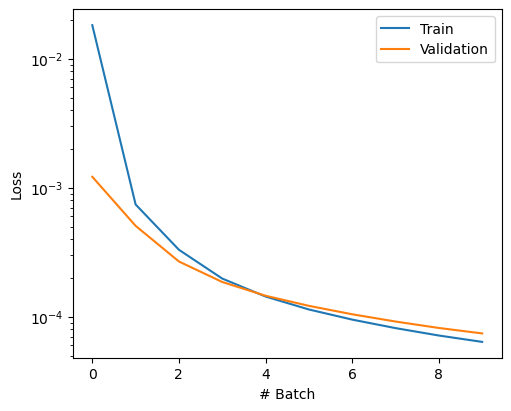

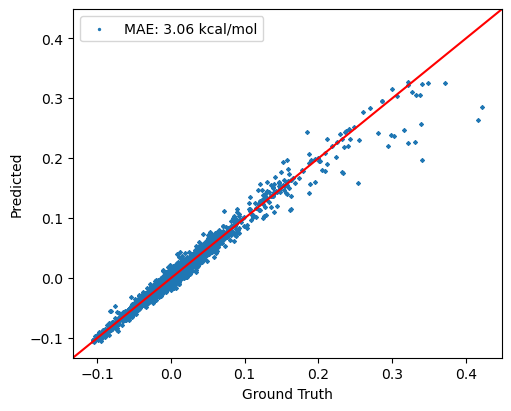

In [26]:
# train the ANITrainer
trainer = ANITrainer(model, batch_size=4096, learning_rate=1e-4, epoch=10, l2=1e-5)
train_loss_list, val_loss_list = trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
val_loss = trainer.evaluate(val_data, draw_plot=True)
print("Validation Loss:", val_loss)

# 3. Regularization and Hyperparameter Tuning

## 3.1. Data Augmentation

In [16]:
!curl -L https://ndownloader.figshare.com/files/9057631 -o ANI1_release.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4584M  100 4584M    0     0  12.8M      0  0:05:57  0:05:57 --:--:-- 19.8M97k


In [21]:
!tar -xzf ANI1_release.tar.gz

In [11]:
import h5py
import glob

def merge_hdf5_groups(input_dir, output_file):
    # file_list = sorted(glob.glob(f"{input_dir}/ani_gdb_s0*.h5"))
    file_list = sorted(glob.glob(f"{input_dir}/ani_gdb_s0[1-6].h5"))
    if not file_list:
        print("No HDF5 files found in the input directory")
        return
    
    with h5py.File(output_file, 'w') as fout:
        for file in file_list:
            print(f"Processing {file}...")
            with h5py.File(file, 'r') as fin:
                for key in fin.keys():
                    new_key = key
                    suffix = 1
                    while new_key in fout:
                        new_key = f"{key}_{suffix}"
                        suffix += 1
                    fin.copy(key, fout, new_key)
                    print(f"Copied group '{key}' as '{new_key}'")
    print(f"Merged groups from {len(file_list)} files into {output_file}")


input_directory = "./ANI-1_release"
output_h5_file = "./ani_gdb_s01_to_s06.h5"
merge_hdf5_groups(input_directory, output_h5_file)

Processing ./ANI-1_release/ani_gdb_s01.h5...
Copied group 'gdb11_s01' as 'gdb11_s01'
Processing ./ANI-1_release/ani_gdb_s02.h5...
Copied group 'gdb11_s02' as 'gdb11_s02'
Processing ./ANI-1_release/ani_gdb_s03.h5...
Copied group 'gdb11_s03' as 'gdb11_s03'
Processing ./ANI-1_release/ani_gdb_s04.h5...
Copied group 'gdb11_s04' as 'gdb11_s04'
Processing ./ANI-1_release/ani_gdb_s05.h5...
Copied group 'gdb11_s05' as 'gdb11_s05'
Processing ./ANI-1_release/ani_gdb_s06.h5...
Copied group 'gdb11_s06' as 'gdb11_s06'
Merged groups from 6 files into ./ani_gdb_s01_to_s06.h5


In [13]:
# Reload the dataset with augmented ANI-1 dataset
dataset = load_ani_dataset("./ani_gdb_s01_to_s04.h5")
# Use dataset.split method to do split
train_data, val_data, test_data = dataset.split(0.8, 0.1, 0.1)

In [7]:
# Initialize aev computer
aev_computer = init_aev_computer()
aev_dim = aev_computer.aev_length
print(aev_dim)

384


## 3.2. Regularization

In [8]:
# Apply Dropout
class AtomicNet(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [9]:
def create_ani_model(dropout_rate=0.0):
    net_H = AtomicNet(dropout_rate)
    net_C = AtomicNet(dropout_rate)
    net_N = AtomicNet(dropout_rate)
    net_O = AtomicNet(dropout_rate)

    # ANI model requires a network for each atom type
    # use torch.ANIModel() to compile atomic networks
    ani_net = torchani.ANIModel([net_H, net_C, net_N, net_O])
    model = nn.Sequential(
        aev_computer,
        ani_net
    ).to(device)
        
    return model

In [10]:
# We already had L2 regularization as `weight_decay`
# Add L1 regularization term
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2, l1=0.0):
        self.model = model.to(device)
        
        # Count total number of parameters
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        # Hyperparameters setting
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        self.l1 = l1  # L1 regularization strength

    def train(self, train_data, val_data, early_stop=True, draw_curve=False):
        self.model.train()
        print("Initializing training data...")
        train_data_loader = train_data.collate(batch_size=self.batch_size).cache()
        
        loss_func = nn.MSELoss()
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        best_weights = None

        for epoch_idx in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            num_samples = 0
            for train_data_batch in train_data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                _, pred_energies = self.model((species, coords))
                batch_loss = loss_func(true_energies, pred_energies)
                
                # Add L1 regularization loss
                if self.l1 > 0:
                    l1_loss = 0.0
                    for param in self.model.parameters():
                        l1_loss += torch.norm(param, 1)
                    batch_loss += self.l1 * l1_loss
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_size_current = species.shape[0]
                train_epoch_loss += batch_loss.item() * batch_size_current
                num_samples += batch_size_current

            train_epoch_loss /= num_samples
            train_loss_list.append(train_epoch_loss)
            val_epoch_loss = self.evaluate(val_data)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    best_weights = self.model.state_dict().copy()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            plt.show()
        
        if early_stop and best_weights is not None:
            self.model.load_state_dict(best_weights)
        
        return train_loss_list, val_loss_list

    def evaluate(self, data, draw_plot=False):
        data_loader = data.collate(batch_size=self.batch_size).cache()
        loss_func = nn.MSELoss()
        total_loss = 0.0
        num_samples = 0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
        
        self.model.eval()
        with torch.no_grad():
            for batch_data in data_loader:
                species = batch_data['species'].to(device)
                coords = batch_data['coordinates'].to(device)
                true_energies = batch_data['energies'].to(device).float()
                
                _, pred_energies = self.model((species, coords))
                batch_loss = loss_func(pred_energies, true_energies)
                batch_size_current = species.shape[0]
                total_loss += batch_loss.item() * batch_size_current
                num_samples += batch_size_current
                
                if draw_plot:
                    true_energies_all.append(true_energies.cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.cpu().numpy().flatten())

        total_loss /= num_samples
        
        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Convert hartree to kcal/mol (1 hartree = 627.5094738898777 kcal/mol)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            vmin = min(ax.get_xlim()[0], ax.get_ylim()[0])
            vmax = max(ax.get_xlim()[1], ax.get_ylim()[1])
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            plt.show()
            
        return total_loss

## 3.3. Hyperparameter Tuning


---- Experiment 1 ----
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 10/10 [08:08<00:00, 48.84s/it]


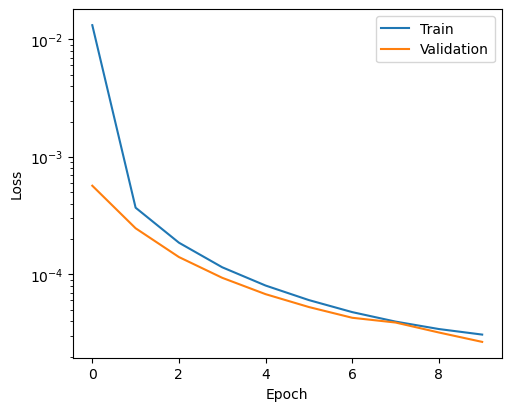

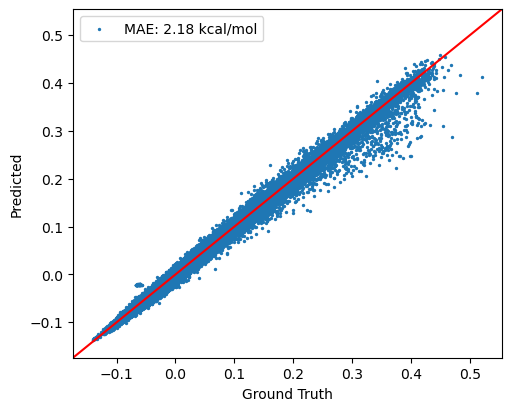

Experiment 1 - Validation Loss: 2.6663946453974443e-05

---- Experiment 2 ----
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 10/10 [06:59<00:00, 41.96s/it]


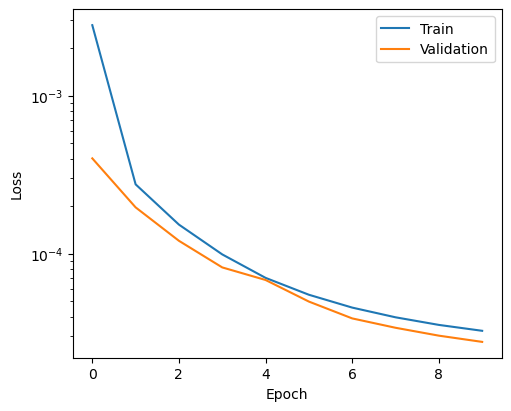

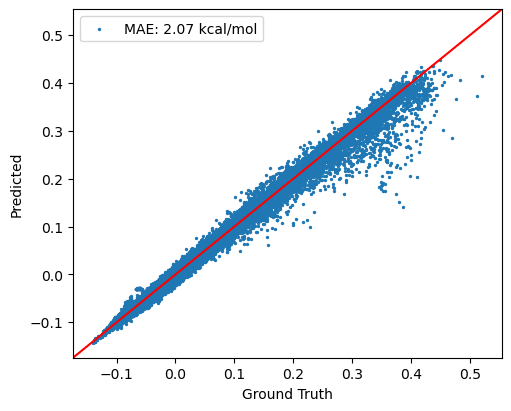

Experiment 2 - Validation Loss: 2.7722288024208172e-05

---- Experiment 3 ----
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 10/10 [08:00<00:00, 48.05s/it]


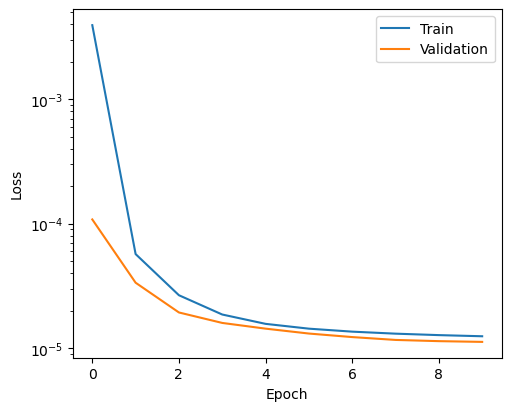

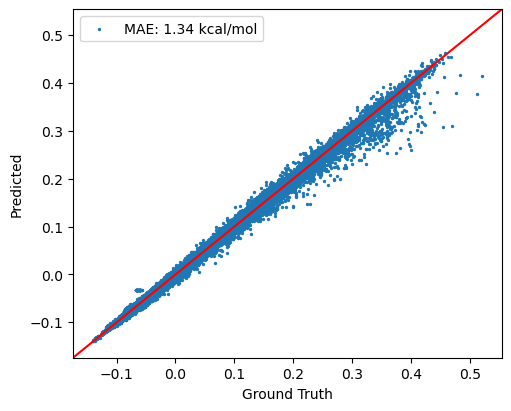

Experiment 3 - Validation Loss: 1.122158933060691e-05


In [14]:
# We will experiment various combination of hyperparameters
# Grid search enables finding optimal hyperparameter setting more efficiently than random search
# Define hyperparameter grids
hyperparams = [
    # (dropout_rate, learning_rate, batch_size, l2, l1, epoch)
    (0.4, 1e-4, 4096, 1e-5, 0.0, 10), # best setting in ckpt3
    (0.0, 1e-4, 4096, 1e-5, 0.0, 10),
    (0.4, 1e-4, 1024, 1e-5, 0.0, 10),
    
]

# Record each experiment's hyperparameters and validation loss
results = []

best_val_loss = np.inf
best_params = None
best_trainer = None

# Grid search loop
for idx, params in enumerate(hyperparams):
    print(f"\n---- Experiment {idx+1} ----")
    dropout_rate, learning_rate, batch_size, l2, l1, epoch = params
    
    # Create a new ANI model using the specified dropout rate
    model = create_ani_model(dropout_rate)
    
    # Initialize the trainer with current hyperparameter settings
    trainer = ANITrainer(model, batch_size, learning_rate, epoch, l2, l1)
    
    trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
    val_loss = trainer.evaluate(val_data, draw_plot=True)
    print(f"Experiment {idx+1} - Validation Loss:",val_loss)
    
    exp_result = {
        'experiment': idx+1,
        'dropout_rate': dropout_rate,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'l2': l2,
        'l1': l1,
        'epoch': epoch,
        'val_loss': val_loss
    }
    results.append(exp_result)
    
    # Based on the current validation loss, update best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        best_trainer = trainer

Grid search results saved to grid_search_results.pkl

---- Best Hyperparameter Combination ----
Dropout Rate: 0.4, Learning Rate: 0.0001, Batch Size: 1024, L2: 1e-05, L1: 0.0, Epoch: 10
Best Validation Loss: 1.122158933060691e-05


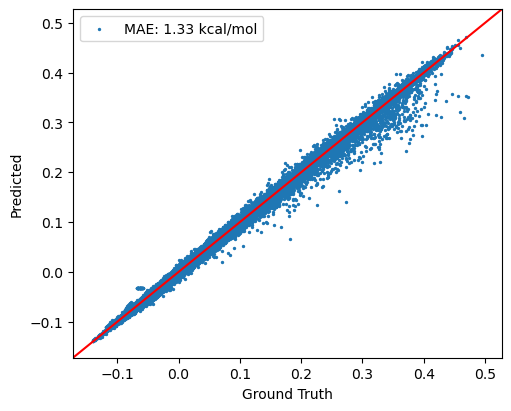

Test Loss: 1.126758717248159e-05


In [16]:
import pickle
with open("grid_search_results.pkl", "wb") as f:
    pickle.dump(results, f)
print("Grid search results saved to grid_search_results.pkl")

print("\n---- Best Hyperparameter Combination ----")
print(f"Dropout Rate: {best_params[0]}, Learning Rate: {best_params[1]}, Batch Size: {best_params[2]}, "
      f"L2: {best_params[3]}, L1: {best_params[4]}, Epoch: {best_params[5]}")
print(f"Best Validation Loss:", best_val_loss)

# Evaluate the best model on test_data
test_loss = best_trainer.evaluate(test_data, draw_plot=True)
print(f"Test Loss:", test_loss)


Grid Search Results:
   experiment  dropout_rate  learning_rate  batch_size       l2   l1  epoch  \
0           1           0.4         0.0001        4096  0.00001  0.0     10   
1           2           0.0         0.0001        4096  0.00001  0.0     10   
2           3           0.4         0.0001        1024  0.00001  0.0     10   

   val_loss  
0  0.000027  
1  0.000028  
2  0.000011  


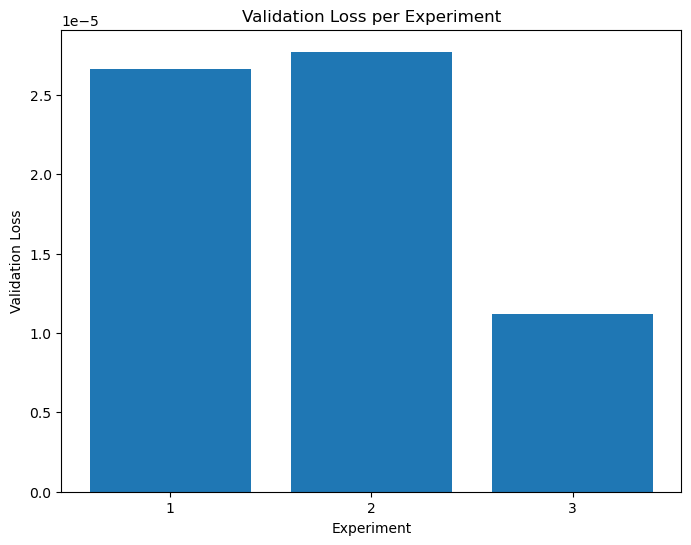

In [17]:
import pandas as pd
df_results = pd.DataFrame(results)
print("\nGrid Search Results:")
print(df_results)

# Visualization of validation loss for each experiment
plt.figure(figsize=(8, 6))
plt.bar(df_results['experiment'].astype(str), df_results['val_loss'])
plt.xlabel('Experiment')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Experiment')
plt.savefig("val_loss_bar.png")
plt.show()

## Interpretation of Results

In checkpoint 3, we used ANI-1 subset of s01 to s06, and we found out hyperparameters as dropout=0.4, batch_size=4096, learning_rate=1e-4, epoch=10, l2=1e-5 as the best model. In checkpoint 4, we checked on the effect of batch size and dropout rate before running k-fold cross validation. The best result was when dropout rate was applied as 0.4, and when batch size was shrinken to 1024. This made MAE 1.33kcal/mol and loss as 0.000011, which is more than two times smaller than the best model we got in checkpoint3.

## 4. K-fold cross validation and Final training

In [11]:
from sklearn.model_selection import KFold

In [12]:
class ANIIndexedSubset:
    def __init__(self, base_dataset, indices):
        self.base_dataset = base_dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.base_dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

    def collate(self, batch_size):
        subset = self.base_dataset.collate(batch_size=batch_size)
        return subset

    def cache(self):
        return self

def k_fold_cv_ani(dataset, k=5, runs=3,
                  dropout_rate=0.4, learning_rate=1e-4,
                  batch_size=1024, l2=1e-5, l1=0.0, epoch=10,
                  shuffle=True, base_seed=None):
    dataset_list   = list(dataset)           
    all_runs_losses, run_stats = [], []

    for run in range(1, runs + 1):
        seed = (base_seed + run) if base_seed is not None else np.random.randint(0, 1_000_000)
        kf   = KFold(n_splits=k, shuffle=shuffle, random_state=seed)

        print(f"\n===== Run {run}/{runs} | seed={seed} =====")
        fold_losses = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_list), 1):
            print(f"\n─── Fold {fold}/{k} ───")

            train_subset = ANIIndexedSubset(dataset, train_idx)
            val_subset   = ANIIndexedSubset(dataset, val_idx)

            model   = create_ani_model(dropout_rate)
            trainer = ANITrainer(model        = model,
                                 batch_size   = batch_size,
                                 learning_rate= learning_rate,
                                 epoch        = epoch,
                                 l2           = l2,
                                 l1           = l1)

            trainer.train(train_subset, val_subset,
                          early_stop=True, draw_curve=False)

            val_loss = trainer.evaluate(val_subset, draw_plot=True)
            print(f"Fold {fold} Validation Loss: {val_loss:.6f}")
            fold_losses.append(val_loss)

        run_mean, run_std = np.mean(fold_losses), np.std(fold_losses)
        print(f"Run {run} Summary → mean {run_mean:.6f}, std {run_std:.6f}")
        all_runs_losses.append(fold_losses)
        run_stats.append((run_mean, run_std))

    overall_mean = np.mean([m for m, _ in run_stats])
    overall_std  = np.std ([m for m, _ in run_stats])
    print("\n===== Overall Summary =====")
    print(f"Avg of run means : {overall_mean:.6f}")
    print(f"Std of run means : {overall_std:.6f}")

    return {
        "fold_losses_per_run": all_runs_losses,
        "run_stats"          : run_stats,   
        "overall_mean"       : overall_mean,
        "overall_std"        : overall_std
    }



===== Run 1/3 | seed=43 =====

─── Fold 1/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:28<00:00, 46.41s/it]


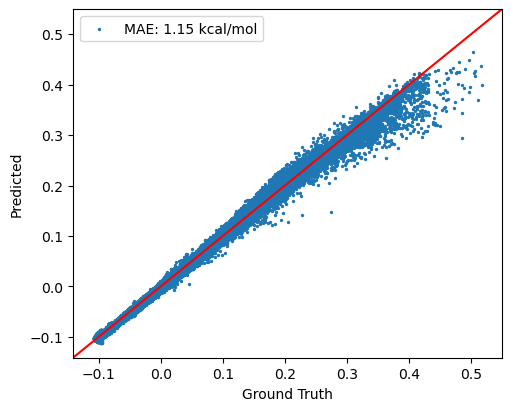

Fold 1 Validation Loss: 0.000009

─── Fold 2/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:28<00:00, 46.44s/it]


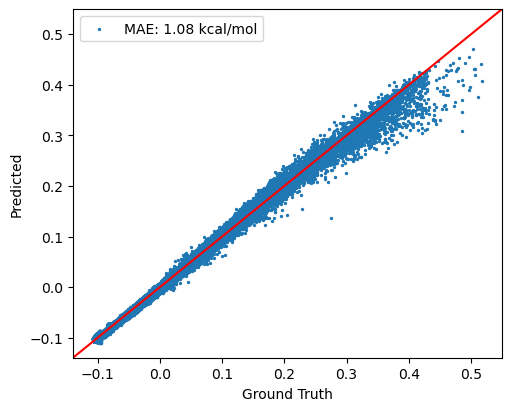

Fold 2 Validation Loss: 0.000008

─── Fold 3/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:27<00:00, 46.40s/it]


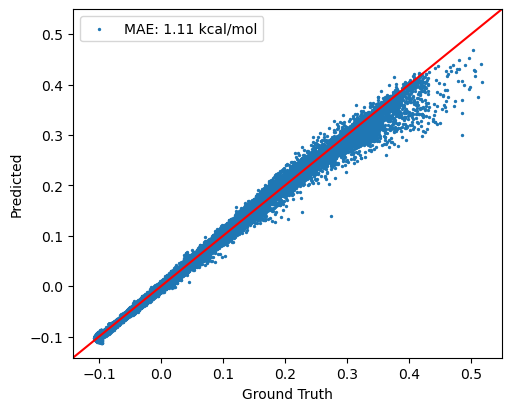

Fold 3 Validation Loss: 0.000009
Run 1 Summary → mean 0.000009, std 0.000000

===== Run 2/3 | seed=44 =====

─── Fold 1/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:44<00:00, 47.24s/it]


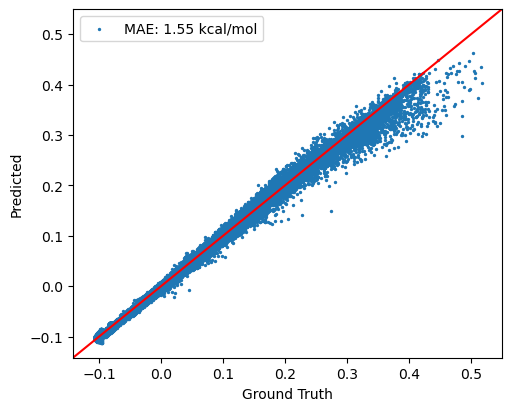

Fold 1 Validation Loss: 0.000013

─── Fold 2/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:31<00:00, 46.60s/it]


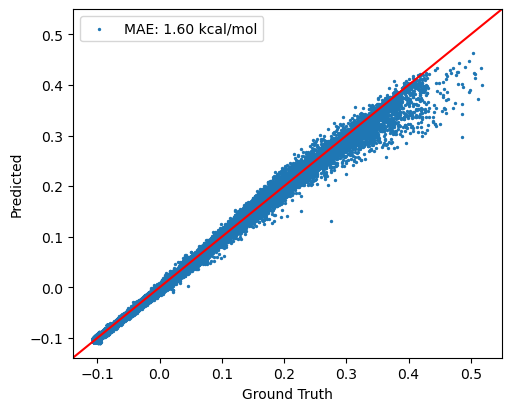

Fold 2 Validation Loss: 0.000013

─── Fold 3/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:30<00:00, 46.51s/it]


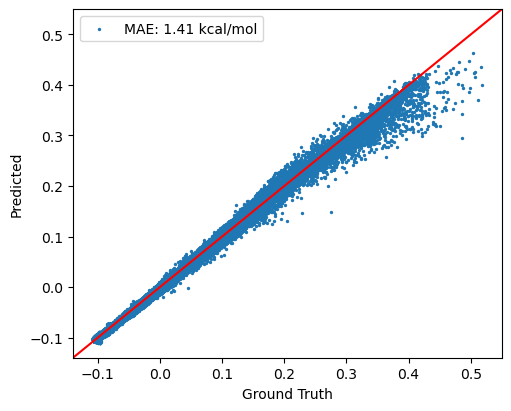

Fold 3 Validation Loss: 0.000012
Run 2 Summary → mean 0.000013, std 0.000001

===== Run 3/3 | seed=45 =====

─── Fold 1/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:30<00:00, 46.50s/it]


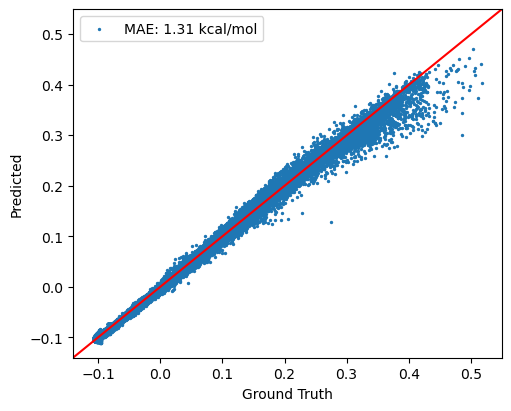

Fold 1 Validation Loss: 0.000011

─── Fold 2/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:44<00:00, 47.23s/it]


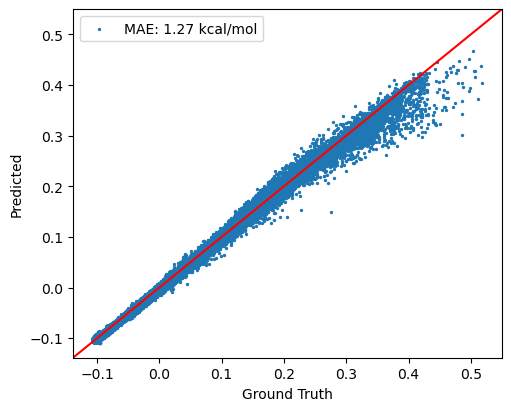

Fold 2 Validation Loss: 0.000010

─── Fold 3/3 ───
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [15:35<00:00, 46.79s/it]


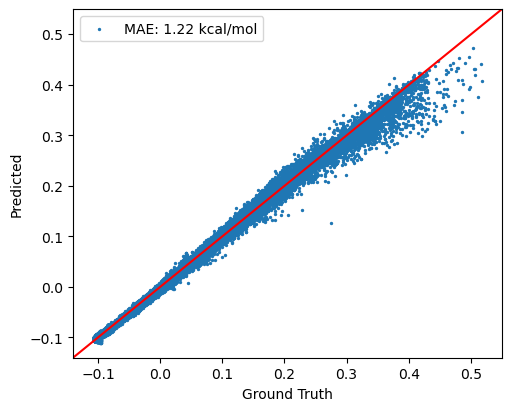

Fold 3 Validation Loss: 0.000010
Run 3 Summary → mean 0.000010, std 0.000000

===== Overall Summary =====
Avg of run means : 0.000011
Std of run means : 0.000002


In [23]:
results = k_fold_cv_ani(
    dataset       = dataset,
    k             = 3,
    runs          = 3,          # multiple runs
    dropout_rate  = 0.4,
    learning_rate = 1e-4,
    batch_size    = 1024,
    l2            = 1e-5,
    l1            = 0.0,
    epoch         = 20,
    base_seed     = 42        
)

In checkpoint 4, we added k-fold cross validation and multiple runs in our existing model.  
We did a 3-fold cross validation with full s01-s04 data, and ran 3 multiple runs. Following are MAE for each run and fold:  
Run1: Fold 1 - 1.15(kcal/mol),Fold 2 - 1.08(kcal/mol), Fold 3 - 1.11(kcal/mol), mean validation loss: 0.000009, std < 1e-6  
Run2: Fold 1 - 1.55(kcal/mol),Fold 2 - 1.60(kcal/mol), Fold 3 - 1.41(kcal/mol), mean validation loss: 0.000013, std = 1e-6  
Run3: Fold 1 - 1.31(kcal/mol),Fold 2 - 1.27(kcal/mol), Fold 3 - 1.22(kcal/mol), mean validation loss: 0.000010, std < 1e-6  

Run 1 showed stable performance, with MAE ranging narrowly from 1.08 to 1.15 kcal/mol across the three folds. Its average validation loss was 0.000009 with a standard deviation below 1e-6, indicating a well-converged and consistent run. For Run 2, it had higher MAE values between 1.41 and 1.60 kcal/mol, and slightly higher mean validation loss and stddev compared to Run 1. This suggests that Run 2 may have been affected by unfavorable initialization or a less optimal data split. Run 3 displayed intermediate performance, with MAE ranging from 1.22 to 1.31 kcal/mol. Overall, although Run 2 had higher MAE than others, we can say that model performs generally well for multiple runs.

For 3-fold cross-validation, when we compare each fold within each run, it showed low variability, which means that our model is generalizing relatively well and not overly sensitive to fold selection.

In conclusion, the model demonstrates reasonable stability and generalization across runs and folds. The errors in Run 2 may indicate sensitivity to initialization, but overall, this result indicates a solid model for us. In checkpoint 5, we will try to compare the results of our model and the model in ANI paper.

## 5. Comparing the MAE/RMSE using different sizes of datasets

In [16]:
# 5 datasets created: s01-s02 ~ s01-s06
import h5py
import glob

def merge_groups(input_dir, output_file):
    # file_list = sorted(glob.glob(f"{input_dir}/ani_gdb_s0*.h5"))
    file_list = sorted(glob.glob(f"{input_dir}/ani_gdb_s0[1-5].h5"))
    if not file_list:
        print("No HDF5 files found in the input directory")
        return
    
    with h5py.File(output_file, 'w') as fout:
        for file in file_list:
            print(f"Processing {file}...")
            with h5py.File(file, 'r') as fin:
                for key in fin.keys():
                    new_key = key
                    suffix = 1
                    while new_key in fout:
                        new_key = f"{key}_{suffix}"
                        suffix += 1
                    fin.copy(key, fout, new_key)
                    print(f"Copied group '{key}' as '{new_key}'")
    print(f"Merged groups from {len(file_list)} files into {output_file}")


input_directory = "./ANI-1_release"
output_h5_file = "./ani_gdb_s01_to_s05.h5"
merge_groups(input_directory, output_h5_file)

Processing ./ANI-1_release/ani_gdb_s01.h5...
Copied group 'gdb11_s01' as 'gdb11_s01'
Processing ./ANI-1_release/ani_gdb_s02.h5...
Copied group 'gdb11_s02' as 'gdb11_s02'
Processing ./ANI-1_release/ani_gdb_s03.h5...
Copied group 'gdb11_s03' as 'gdb11_s03'
Processing ./ANI-1_release/ani_gdb_s04.h5...
Copied group 'gdb11_s04' as 'gdb11_s04'
Processing ./ANI-1_release/ani_gdb_s05.h5...
Copied group 'gdb11_s05' as 'gdb11_s05'
Merged groups from 5 files into ./ani_gdb_s01_to_s05.h5


In [11]:
class ANITrainer:
    def __init__(self, model, batch_size, learning_rate, epoch, l2, l1=0.0):
        self.model = model.to(device)
        
        # Count total number of parameters
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        # Hyperparameters setting
        self.batch_size = batch_size
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        self.epoch = epoch
        self.l1 = l1  # L1 regularization strength

    def train(self, train_data, val_data, early_stop=True, draw_curve=False):
        self.model.train()
        print("Initializing training data...")
        train_data_loader = train_data.collate(batch_size=self.batch_size).cache()
        
        loss_func = nn.MSELoss()
        train_loss_list = []
        val_loss_list = []
        lowest_val_loss = np.inf
        best_weights = None

        for epoch_idx in tqdm(range(self.epoch), leave=True):
            train_epoch_loss = 0.0
            num_samples = 0
            for train_data_batch in train_data_loader:
                species = train_data_batch['species'].to(device)
                coords = train_data_batch['coordinates'].to(device)
                true_energies = train_data_batch['energies'].to(device).float()
                
                _, pred_energies = self.model((species, coords))
                batch_loss = loss_func(true_energies, pred_energies)
                
                # Add L1 regularization loss
                if self.l1 > 0:
                    l1_loss = 0.0
                    for param in self.model.parameters():
                        l1_loss += torch.norm(param, 1)
                    batch_loss += self.l1 * l1_loss
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                batch_size_current = species.shape[0]
                train_epoch_loss += batch_loss.item() * batch_size_current
                num_samples += batch_size_current

            train_epoch_loss /= num_samples
            train_loss_list.append(train_epoch_loss)
            val_epoch_loss = self.evaluate(val_data)
            val_loss_list.append(val_epoch_loss)
            
            if early_stop:
                if val_epoch_loss < lowest_val_loss:
                    lowest_val_loss = val_epoch_loss
                    best_weights = self.model.state_dict().copy()
        
        if draw_curve:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.set_yscale("log")
            ax.plot(range(len(train_loss_list)), train_loss_list, label='Train')
            ax.plot(range(len(val_loss_list)), val_loss_list, label='Validation')
            ax.legend()
            ax.set_xlabel("Epoch")
            ax.set_ylabel("Loss")
            plt.show()
        
        if early_stop and best_weights is not None:
            self.model.load_state_dict(best_weights)
        
        return train_loss_list, val_loss_list

    def evaluate(self, data, draw_plot=False):
        data_loader = data.collate(batch_size=self.batch_size).cache()
        loss_func = nn.MSELoss()
        total_loss = 0.0
        num_samples = 0
        
        if draw_plot:
            true_energies_all = []
            pred_energies_all = []
        
        self.model.eval()
        with torch.no_grad():
            for batch_data in data_loader:
                species = batch_data['species'].to(device)
                coords = batch_data['coordinates'].to(device)
                true_energies = batch_data['energies'].to(device).float()
                
                _, pred_energies = self.model((species, coords))
                batch_loss = loss_func(pred_energies, true_energies)
                batch_size_current = species.shape[0]
                total_loss += batch_loss.item() * batch_size_current
                num_samples += batch_size_current
                
                if draw_plot:
                    true_energies_all.append(true_energies.cpu().numpy().flatten())
                    pred_energies_all.append(pred_energies.cpu().numpy().flatten())

        total_loss /= num_samples
        
        if draw_plot:
            true_energies_all = np.concatenate(true_energies_all)
            pred_energies_all = np.concatenate(pred_energies_all)
            # Convert hartree to kcal/mol (1 hartree = 627.5094738898777 kcal/mol)
            hartree2kcalmol = 627.5094738898777
            mae = np.mean(np.abs(true_energies_all - pred_energies_all)) * hartree2kcalmol
            rmse = np.sqrt(np.mean((true_energies_all - pred_energies_all)**2)) * hartree2kcalmol
            fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
            ax.scatter(true_energies_all, pred_energies_all, label=f"MAE: {mae:.2f} kcal/mol, RMSE: {rmse:.2f} kcal/mol", s=2)
            ax.set_xlabel("Ground Truth")
            ax.set_ylabel("Predicted")
            vmin = min(ax.get_xlim()[0], ax.get_ylim()[0])
            vmax = max(ax.get_xlim()[1], ax.get_ylim()[1])
            ax.set_xlim(vmin, vmax)
            ax.set_ylim(vmin, vmax)
            ax.plot([vmin, vmax], [vmin, vmax], color='red')
            ax.legend()
            plt.show()
            
        return total_loss


📂 dataset: .//ani_gdb_s01_to_s02.h5
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 30/30 [00:23<00:00,  1.29it/s]


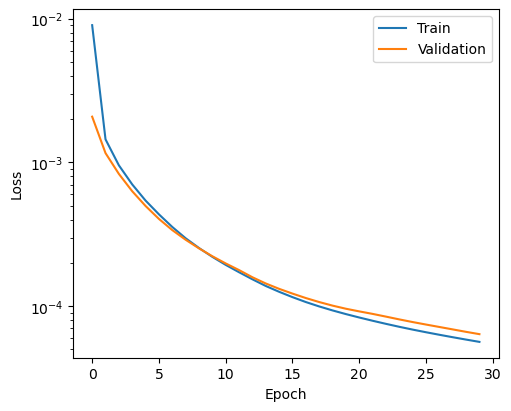

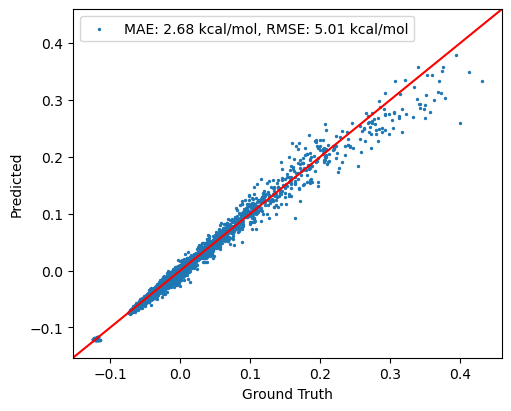

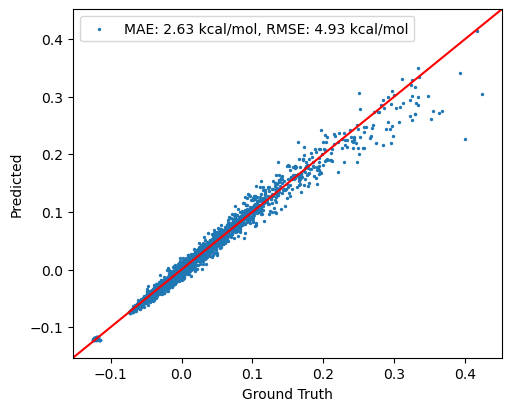

Validation Loss: 6.372562762370353e-05
Test Loss: 6.171828467601553e-05

📂 dataset: .//ani_gdb_s01_to_s03.h5
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 30/30 [01:15<00:00,  2.51s/it]


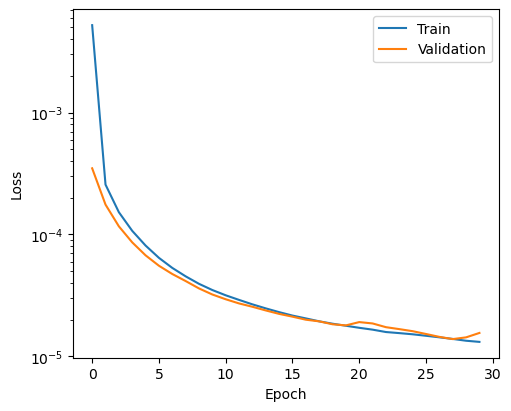

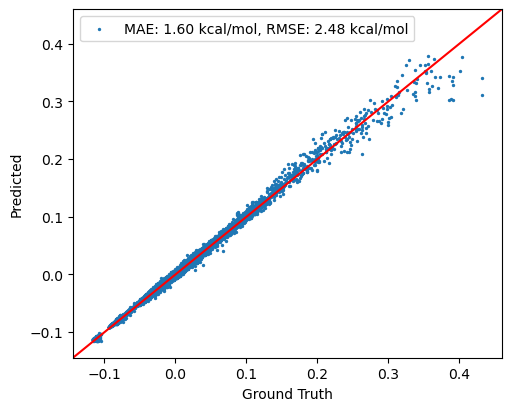

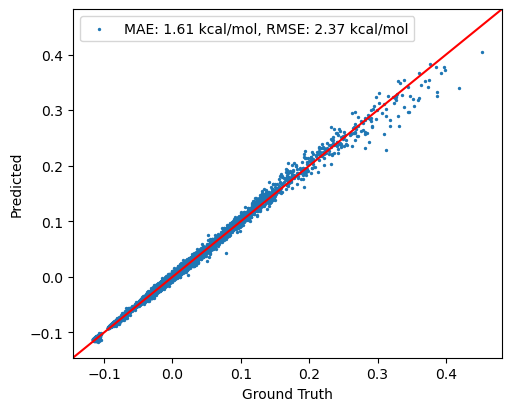

Validation Loss: 1.5557662555275736e-05
Test Loss: 1.4312813332434506e-05

📂 dataset: .//ani_gdb_s01_to_s04.h5
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 30/30 [04:07<00:00,  8.24s/it]


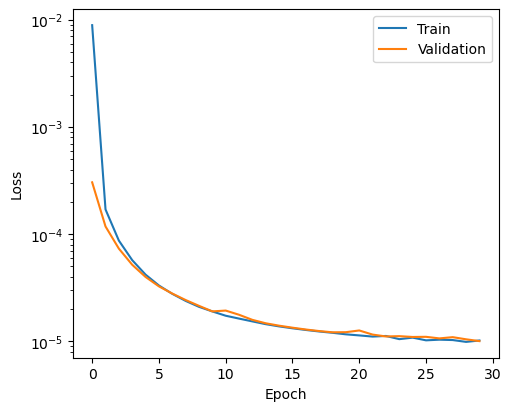

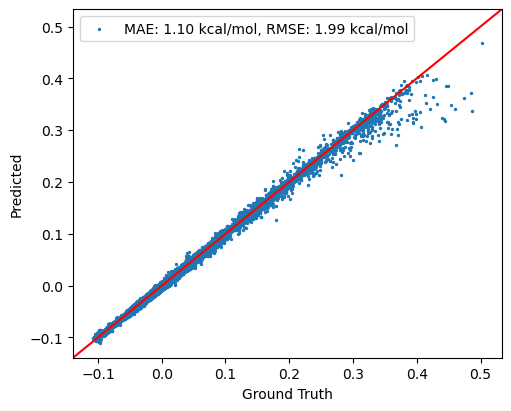

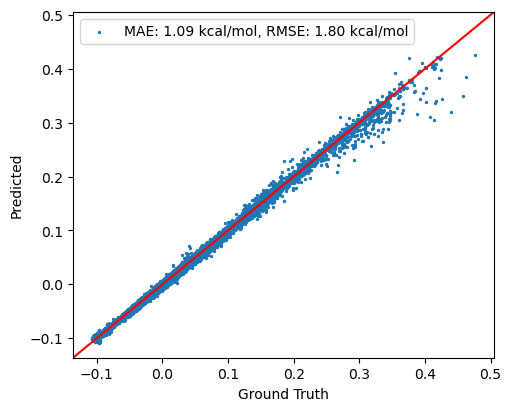

Validation Loss: 1.006112597727919e-05
Test Loss: 8.202326538819707e-06

📂 dataset: .//ani_gdb_s01_to_s05.h5
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 30/30 [15:30<00:00, 31.03s/it]


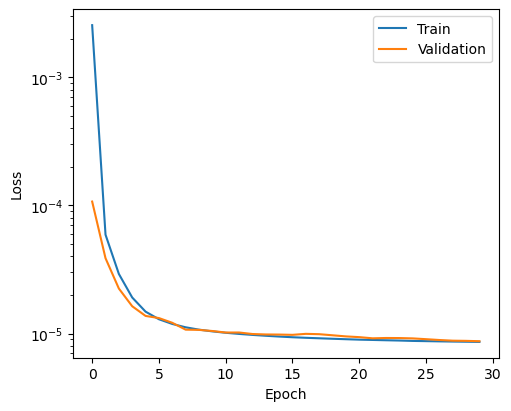

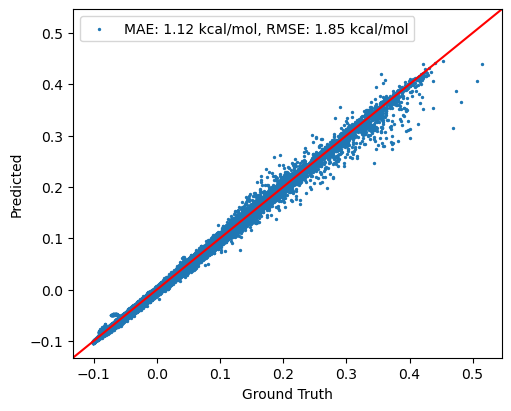

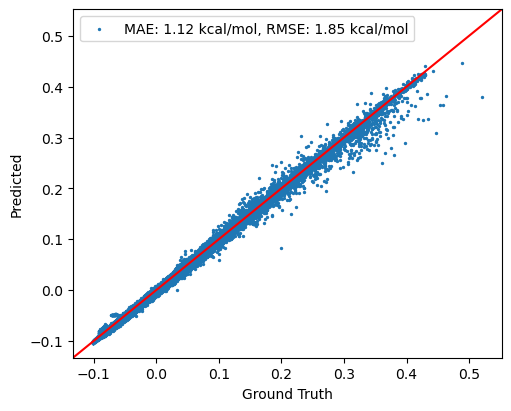

Validation Loss: 8.720359703456028e-06
Test Loss: 8.659006739288103e-06

📂 dataset: .//ani_gdb_s01_to_s06.h5
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 30/30 [28:05<00:00, 56.19s/it]


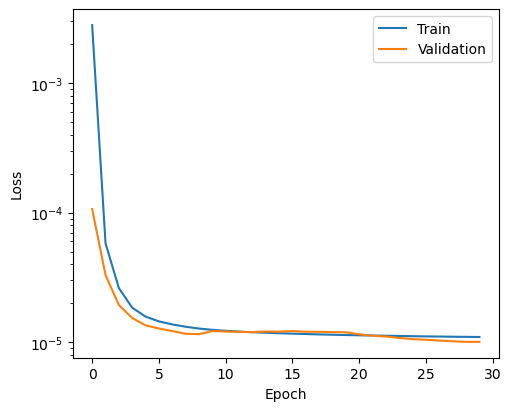

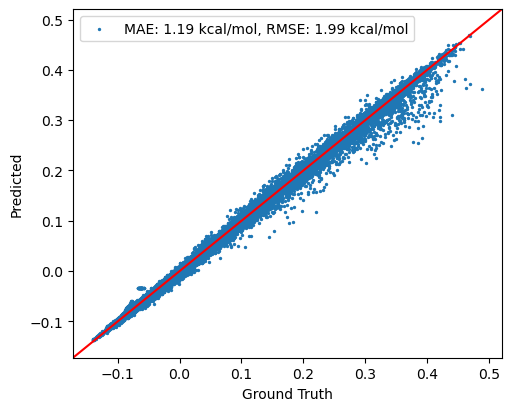

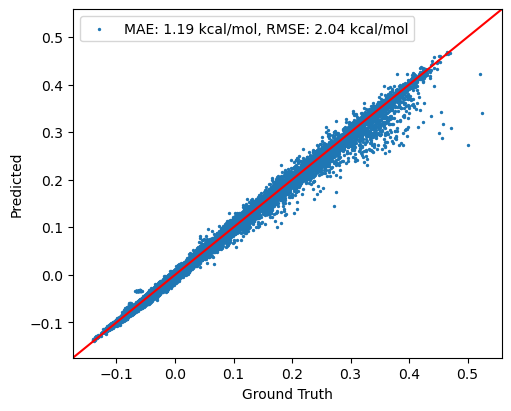

Validation Loss: 1.0076310903284584e-05
Test Loss: 1.0548028713799013e-05


In [23]:
for k in range(2,7):
    h5_path = f"{BASE_PATH}/ani_gdb_s01_to_s0{k}.h5"
    print(f"\n📂 dataset: {h5_path}")

    dataset = load_ani_dataset(h5_path)
    train_data, val_data, test_data = dataset.split(0.8,0.1,0.1)        

    aev_computer = init_aev_computer()            
    model = create_ani_model(dropout_rate=0.4)
    trainer = ANITrainer(model,
                         batch_size=1024,
                         learning_rate=1e-4,
                         epoch=30,
                         l2=1e-5, l1=0.0)
    
    trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
    val_loss = trainer.evaluate(val_data, draw_plot=True)
    test_loss = trainer.evaluate(test_data, draw_plot=True)
    print(f"Validation Loss:",val_loss)
    print(f"Test Loss:", test_loss)
    


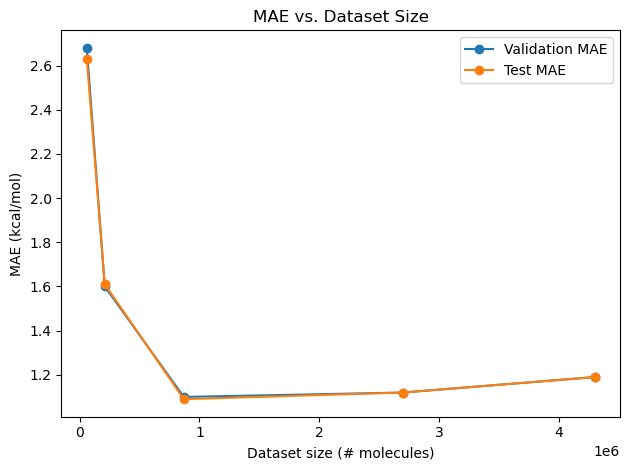

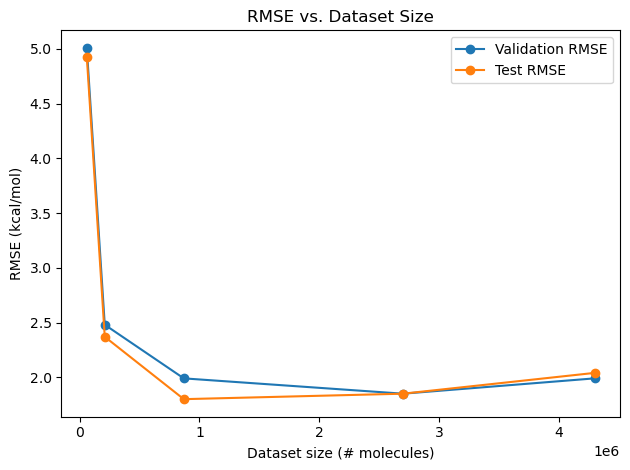

In [1]:
import numpy as np
import matplotlib.pyplot as plt                

sizes = [0.06*1e6, 0.21*1e6, 0.87*1e6, 2.7*1e6, 4.3*1e6] 
sizes = np.array(sizes)


val_mae  = np.array([2.68, 1.60, 1.10, 1.12, 1.19])
test_mae = np.array([2.63, 1.61, 1.09, 1.12, 1.19])

val_rmse  = np.array([5.01, 2.48, 1.99, 1.85, 1.99])
test_rmse = np.array([4.93, 2.37, 1.80, 1.85, 2.04])

# -------------------------------------------------------------
# 3) MAE line graph
# -------------------------------------------------------------
plt.figure()
plt.plot(sizes, val_mae,  marker="o", label="Validation MAE")
plt.plot(sizes, test_mae, marker="o", label="Test MAE")
plt.xlabel("Dataset size (# molecules)")
plt.ylabel("MAE (kcal/mol)")
plt.title("MAE vs. Dataset Size")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) RMSE line graph
# -------------------------------------------------------------
plt.figure()
plt.plot(sizes, val_rmse,  marker="o", label="Validation RMSE")
plt.plot(sizes, test_rmse, marker="o", label="Test RMSE")
plt.xlabel("Dataset size (# molecules)")
plt.ylabel("RMSE (kcal/mol)")
plt.title("RMSE vs. Dataset Size")
plt.legend()
plt.tight_layout()
plt.show()


In checkpoint 5, we finalized our model and compared the effect of dataset size. In ANI paper(Smith et al., Chem. Sci., 2017), it discussed the effect of dataset sizes and RMSE (Fig 3). The graph in ANI paper showed steady decreasement of RMSE as the dataset size increased, except the case for s01-s08, where the RMSE increased slightly. For comparison, we also trained our own model with dataset s01-s02 to s01-s06 and calculated its MAE and RMSE each, putting them on a line graph. The graph shows decreasement of RMSE as the dataset size increases, but the RMSE did not steadily get better after 1e6 number of datasets. The reason of this might be the lack of parameters - in ANI paper, they used more parameters and more hidden layers, but our model architecture might be a bit shallow for larger datasets to be utilized well. For the RMSE itself, it was around 1.4-1.5kcal/mol for s01-s06 datasets in ANI paper. Our model shows 1.8-2.0kcal/mol RMSE, which is slightly larger than ANI paper. This might be because of lack of parameters and different architecture of model. Also, as we trained with less epochs due to computing power, it might have not reached minimum loss, which can lead to larger RMSE. 

## Additional Tuning: Learning Rate


📂 dataset: .//ani_gdb_s01_to_s04.h5
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 30/30 [05:03<00:00, 10.10s/it]


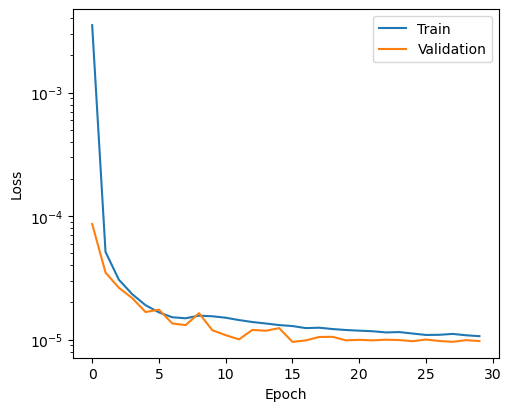

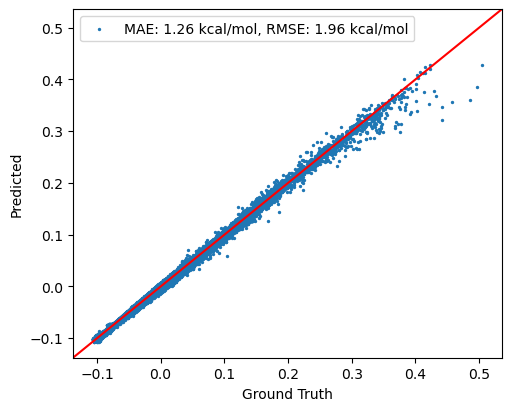

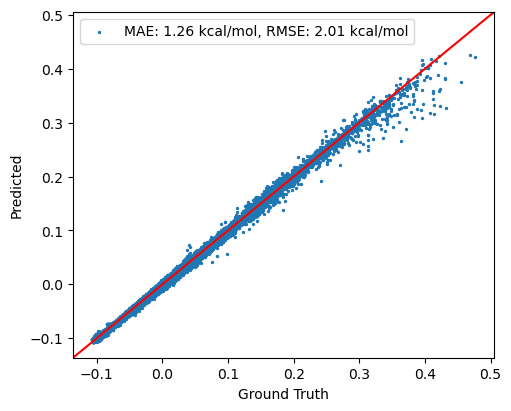

Validation Loss: 9.744533315857073e-06
Test Loss: 1.0243537022980101e-05


In [17]:
h5_path = f".//ani_gdb_s01_to_s04.h5"
print(f"\n📂 dataset: {h5_path}")

dataset = load_ani_dataset(h5_path)
train_data, val_data, test_data = dataset.split(0.8,0.1,0.1)        

aev_computer = init_aev_computer()            
model = create_ani_model(dropout_rate=0.4)
trainer = ANITrainer(model,
                        batch_size=1024,
                        learning_rate=5e-4,
                        epoch=30,
                        l2=1e-5, l1=0.0)
    
trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
val_loss = trainer.evaluate(val_data, draw_plot=True)
test_loss = trainer.evaluate(test_data, draw_plot=True)
print(f"Validation Loss:",val_loss)
print(f"Test Loss:", test_loss)

We also thought maybe learning rate is too low for larger datasets, and it could lead to RMSE/MAE not improving as before. We trained the model with lr=5*1e-4 for s01-s04 datasets with 30 epochs to look at the effect of larger learning rate. However, the training and validation loss curve were not significantly improving despite the learning rate change, and MAE/RMSE were slightly worse compared to results with lr=1e-4. We can conclude the the learning rate we initially chose (1e-4) is suitable for our model.

## Experiment on Different Activation Functions

In [34]:
# 1) Define two Atomic Net using different activation functions
class AtomicNetReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear( aev_computer.aev_length, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x)

class Gaussian(nn.Module):
    """Custom Gaussian activation: exp(-x^2)"""
    def forward(self, x):
        return torch.exp(-x * x)

class AtomicNetGaussian(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(aev_computer.aev_length, 128),
            Gaussian(),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        return self.net(x)

def create_model(factory):
    nets = [factory() for _ in range(4)]
    return nn.Sequential(aev_computer, torchani.ANIModel(nets))


📂 dataset: .//ani_gdb_s01_to_s04.h5

=== Training with ReLU activation ===
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [03:34<00:00, 10.72s/it]


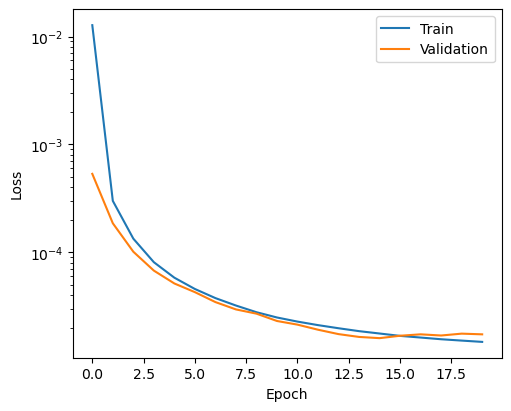

ReLU final validation RMSE: 2.61 kcal/mol

=== Training with Gaussian activation ===
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 20/20 [03:25<00:00, 10.27s/it]


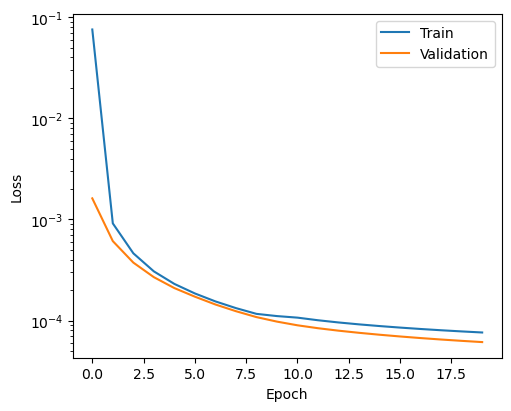

Gaussian final validation RMSE: 4.91 kcal/mol


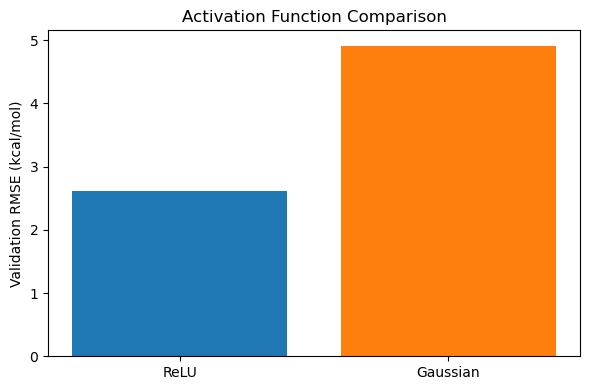

In [37]:
# 2) Experiment loop
h5_path = f".//ani_gdb_s01_to_s04.h5"
print(f"\n📂 dataset: {h5_path}")

dataset = load_ani_dataset(h5_path)
train_data, val_data, test_data = dataset.split(0.8,0.1,0.1)

hartree2kcalmol = 627.5094738898777

results = {}
for name, factory in [("ReLU", AtomicNetReLU), ("Gaussian", AtomicNetGaussian)]:
    print(f"\n=== Training with {name} activation ===")
    model = create_model(factory).to(device)
    trainer = ANITrainer(
        model,
        batch_size    = 1024,
        learning_rate = 1e-4,
        epoch         = 20,
        l2            = 1e-5,
        l1            = 0.0
    )

    train_losses, val_losses = trainer.train(
        train_data, val_data,
        early_stop = True,
        draw_curve = True
    )

    final_val_mse = val_losses[-1]
    final_val_rmse_kcal = np.sqrt(final_val_mse) * hartree2kcalmol
    results[name] = final_val_rmse_kcal
    print(f"{name} final validation RMSE: {final_val_rmse_kcal:.2f} kcal/mol")

# 3) Visualization
plt.figure(figsize=(6,4))
plt.bar(results.keys(), results.values(), color=['C0','C1'])
plt.ylabel("Validation RMSE (kcal/mol)")
plt.title("Activation Function Comparison")
plt.tight_layout()
plt.show()

We tried different activation functions to see the difference on the performance of model. In ANI paper, the model used Gaussian function, and our model initially used ReLU. Therefore, we compared the performance when we use ReLU and Gaussian in same condition. We trained for 20 epochs and the validation RMSE was 2.61kcal/

## Effect of Dropout


📂 dataset: .//ani_gdb_s01_to_s06.h5
Sequential - Number of parameters: 197636
Initializing training data...


100%|██████████| 30/30 [39:59<00:00, 80.00s/it]


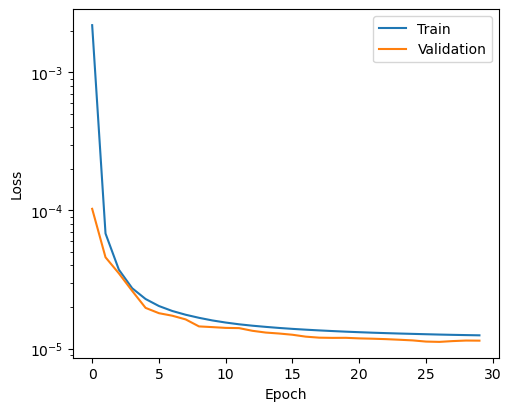

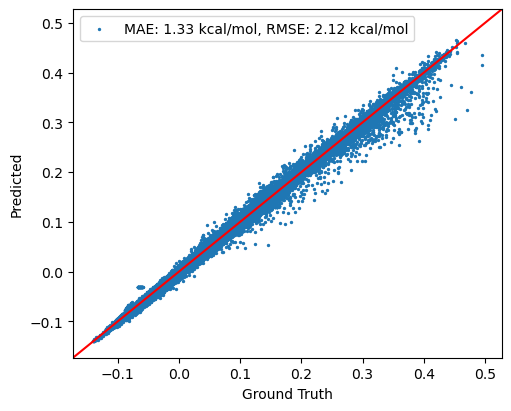

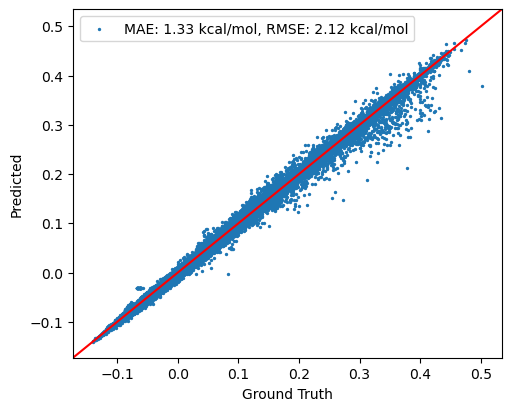

Validation Loss: 1.1402831919662994e-05
Test Loss: 1.145115648673928e-05


In [12]:
h5_path = f".//ani_gdb_s01_to_s06.h5"
print(f"\n📂 dataset: {h5_path}")

dataset = load_ani_dataset(h5_path)
train_data, val_data, test_data = dataset.split(0.8,0.1,0.1)        

aev_computer = init_aev_computer()            
model = create_ani_model(dropout_rate=0.0)
trainer = ANITrainer(model,
                         batch_size=1024,
                         learning_rate=1e-4,
                         epoch=30,
                         l2=1e-5, l1=0.0)
    
trainer.train(train_data, val_data, early_stop=True, draw_curve=True)
val_loss = trainer.evaluate(val_data, draw_plot=True)
test_loss = trainer.evaluate(test_data, draw_plot=True)
print(f"Validation Loss:",val_loss)
print(f"Test Loss:", test_loss)

We tried to find out the effect of dropout in large epochs by training model with s01-s06 data and dropout rate = 0.0. Compared to the model we trained before with dropout = 0.4 (RMSE=1.99kcal/mol), the RMSE was higher (2.12kcal/mol). This indicates that when there are large epochs, without dropout the model may begin to overfit, memorizing training data and generalizing poorly to validation data. In contrast, adding the dropout helps by regularizing the model, preventing overfitting, and improving generalization, thus leading to a lower RMSE.
